In [ ]:
# Student Number : 008799

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from plotly.offline import init_notebook_mode,iplot
import matplotlib as mpl
import matplotlib.pyplot as plt
from subprocess import check_output
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
from gensim.parsing.porter import PorterStemmer
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Reading the movies and reviews datatsets
movies_df = pd.read_csv('rotten_tomatoes_movies.csv')
reviews_df = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

In [4]:
# Creating the stopwords
stopwords = set(STOPWORDS)

# This function makes wordclouds for the supplied dataframe
def topicWordCloud(subset):
    wordcloud = WordCloud(width=1800, height=1200,
                      background_color='white',
                      stopwords=stopwords,
                      max_words=200,
                      min_font_size=20,
                      random_state=42).generate(str(subset))
    return wordcloud

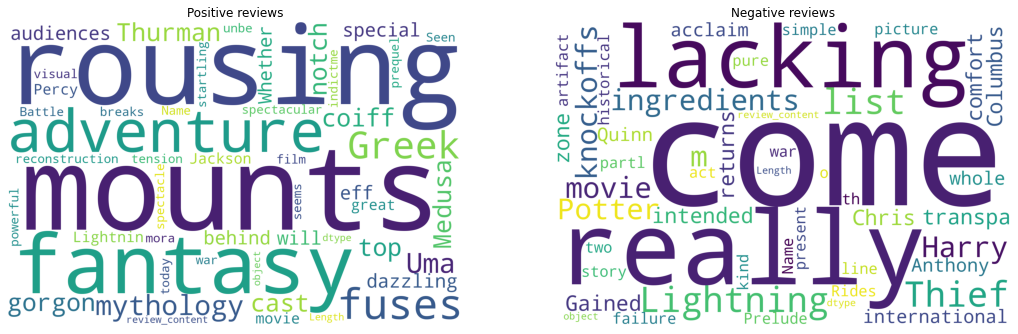

In [5]:
# This piece of code prints the wordclouds for positive and negative reviews

fig = plt.figure(figsize=(18, 12), facecolor=None)
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    if i+1 == 1:
        subset = reviews_df[reviews_df['review_type'] == 'Fresh']['review_content']
        subset = subset.dropna()
        plot_title = 'Positive reviews'
    elif i+1 == 2:
        subset = reviews_df[reviews_df['review_type'] == 'Rotten']['review_content']
        subset = subset.dropna()
        plot_title = 'Negative reviews'
    wordcloud = topicWordCloud(subset)
    plt.title(plot_title)
    ax.imshow(wordcloud)
    ax.axis('off')

In [6]:
# This piece of code concatenates the two dataframes into a single dataframe to be used

dff = reviews_df[['rotten_tomatoes_link','review_type','review_date','review_content']]
# Getting movie name from the movie link
dff['movie_name'] = dff['rotten_tomatoes_link'].map(movies_df.set_index('rotten_tomatoes_link')['movie_title'])
# Read genre with movie link as keyword
dff['genres'] = dff['rotten_tomatoes_link'].map(movies_df.set_index('rotten_tomatoes_link')['genres'])
# Read reease date with movie link as keyword
dff['original_release_date'] = dff['rotten_tomatoes_link'].map(movies_df.set_index('rotten_tomatoes_link')['original_release_date'])
dff = dff[['rotten_tomatoes_link','movie_name','original_release_date','genres','review_date','review_type','review_content']]
# Remove rows with Null values
dff = dff[dff.original_release_date.notnull()]
dff = dff[dff.review_content.notnull()]
# Change release date and review date to datatime format and extract year
dff['original_release_date'] = pd.to_datetime(dff['original_release_date'])
dff['movie_year'] = dff['original_release_date'].apply(lambda x: x.year)
dff['review_date'] = pd.to_datetime(dff['review_date'])
dff['review_year'] = dff['review_date'].apply(lambda x: x.year)

# Extract single genre from the genre column
dff['first_genre'] = dff['genres'].str.split(',').str[0]
dff.head(5)

,rotten_tomatoes_link,movie_name,original_release_date,genres,review_date,review_type,review_content,movie_year,review_year,first_genre
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-06,Fresh,A fantasy adventure that fuses Greek mythology...,2010,2010,Action & Adventure
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-06,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",2010,2010,Action & Adventure
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-09,Fresh,With a top-notch cast and dazzling special eff...,2010,2010,Action & Adventure
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-09,Fresh,Whether audiences will get behind The Lightnin...,2010,2010,Action & Adventure
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-10,Rotten,What's really lacking in The Lightning Thief i...,2010,2010,Action & Adventure


In [10]:
# Pre-processing

# Removing punctuations and special charecters
dff['review_cleaned'] = dff.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['review_content'])),axis=1)
dff['review_cleaned'] = dff.apply(lambda row: (re.sub("\'", ' ', row['review_cleaned'])),axis=1)

# Tokenise the text
dff['review_cleaned'] = dff.apply(lambda row: (word_tokenize(row['review_cleaned'].upper())), axis = 1)
dff.head(5)

,rotten_tomatoes_link,movie_name,original_release_date,genres,review_date,review_type,review_content,movie_year,review_year,first_genre,review_cleaned
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-06,Fresh,A fantasy adventure that fuses Greek mythology...,2010,2010,Action & Adventure,"[A, FANTASY, ADVENTURE, THAT, FUSES, GREEK, MY..."
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-06,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",2010,2010,Action & Adventure,"[UMA, THURMAN, AS, MEDUSA, THE, GORGON, WITH, ..."
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-09,Fresh,With a top-notch cast and dazzling special eff...,2010,2010,Action & Adventure,"[WITH, A, TOP, NOTCH, CAST, AND, DAZZLING, SPE..."
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-09,Fresh,Whether audiences will get behind The Lightnin...,2010,2010,Action & Adventure,"[WHETHER, AUDIENCES, WILL, GET, BEHIND, THE, L..."
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-10,Rotten,What's really lacking in The Lightning Thief i...,2010,2010,Action & Adventure,"[WHAT, S, REALLY, LACKING, IN, THE, LIGHTNING,..."


In [11]:
# Download the stopwords in english 
from nltk.corpus import stopwords
stop_words = set([i.upper() for i in stopwords.words('english')])

# Remove the stopwords 
dff['review_cleaned'] = dff.apply(lambda row: ([w for w in row['review_cleaned'] if w not in stop_words]),axis=1)

dff.head(5)

,rotten_tomatoes_link,movie_name,original_release_date,genres,review_date,review_type,review_content,movie_year,review_year,first_genre,review_cleaned
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-06,Fresh,A fantasy adventure that fuses Greek mythology...,2010,2010,Action & Adventure,"[FANTASY, ADVENTURE, FUSES, GREEK, MYTHOLOGY, ..."
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-06,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",2010,2010,Action & Adventure,"[UMA, THURMAN, MEDUSA, GORGON, COIFFURE, WRITH..."
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-09,Fresh,With a top-notch cast and dazzling special eff...,2010,2010,Action & Adventure,"[TOP, NOTCH, CAST, DAZZLING, SPECIAL, EFFECTS,..."
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-09,Fresh,Whether audiences will get behind The Lightnin...,2010,2010,Action & Adventure,"[WHETHER, AUDIENCES, GET, BEHIND, LIGHTNING, T..."
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-10,Rotten,What's really lacking in The Lightning Thief i...,2010,2010,Action & Adventure,"[REALLY, LACKING, LIGHTNING, THIEF, GENUINE, S..."


In [12]:
# Stem the tokens
porter_stemmer = PorterStemmer()
dff['review_cleaned'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in dff['review_cleaned']]
dff.head(5)

,rotten_tomatoes_link,movie_name,original_release_date,genres,review_date,review_type,review_content,movie_year,review_year,first_genre,review_cleaned
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-06,Fresh,A fantasy adventure that fuses Greek mythology...,2010,2010,Action & Adventure,"[fantasi, adventur, fuse, greek, mytholog, con..."
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-06,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",2010,2010,Action & Adventure,"[uma, thurman, medusa, gorgon, coiffur, writh,..."
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-09,Fresh,With a top-notch cast and dazzling special eff...,2010,2010,Action & Adventure,"[top, notch, cast, dazzl, special, effect, tid..."
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-09,Fresh,Whether audiences will get behind The Lightnin...,2010,2010,Action & Adventure,"[whether, audienc, get, behind, lightn, thief,..."
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,"Action & Adventure, Comedy, Drama, Science Fic...",2010-02-10,Rotten,What's really lacking in The Lightning Thief i...,2010,2010,Action & Adventure,"[realli, lack, lightn, thief, genuin, sens, wo..."


In [13]:
# split the data for testing (30%) and training (70%)
X_train, X_test, y_train, y_test = train_test_split(dff[['rotten_tomatoes_link','movie_year','review_content','review_cleaned']], 
                                                        dff['review_type'], shuffle=True, test_size=0.3, random_state=24)

In [45]:
print(y_train.value_counts())
print(y_test.value_counts())

Fresh     465822
Rotten    263683
Name: review_type, dtype: int64
Fresh     200173
Rotten    112473
Name: review_type, dtype: int64


In [17]:
# TaggedDocuments are tuple of stemmed tokens and class lable
docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(dff['review_cleaned'])]
print(docs[10])

# Initialize the  doc2vec model
doc2vec_model = Doc2Vec(docs, vector_size=300, window=8, min_count=1, workers=4)

TaggedDocument(['action', 'pack', 'fantasi', 'adventur', 'base', 'rick', 'riordan', 'hit', 'perci', 'jackson', 'olympian', 'seri', 'book', 'great', 'fun', 'deserv', 'find', 'audienc', 'teen', 'bereft', 'harri', 'potter', 'magic'], [10])


In [26]:
# Sample vector for the stemmed tokens
vector = doc2vec_model.infer_vector(dff['review_cleaned'][0])
# Printing sample vector
print(len(vector))
print("Top 10 values in Doc2Vec inferred vector:")
print(vector[:10])

300
Top 10 values in Doc2Vec inferred vector:
[-0.05294748  0.00540731 -0.09017408  0.04494627 -0.13275896  0.03640092
 -0.03576714  0.04224482  0.03163871  0.01573218]


In [27]:
start_time = time.time()
# Store the vectors for train data in 
doc2vec_filename = 'train_review_doc2vec.csv'
with open(doc2vec_filename, 'w+') as doc2vec_file:
    for index, row in X_train.iterrows():
        model_vector = doc2vec_model.infer_vector(row['review_cleaned'])
        if index == 0:
            header = ",".join(str(ele) for ele in range(300))
            doc2vec_file.write(header)
            doc2vec_file.write("\n")
        line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        doc2vec_file.write(line1)
        doc2vec_file.write('\n')
print("Time taken to create doc2vec vectors: " + str(time.time() - start_time))

Time taken to create doc2vec vectors: 580.5775034427643


In [28]:
# Read the doc2vec model vectors

doc2vec_filename = 'train_review_doc2vec.csv'
doc2vec_df = pd.read_csv(doc2vec_filename)

In [29]:
# Initialize Logistic Regression model

clf_log_doc2vec = make_pipeline(StandardScaler(), LogisticRegression())
# Fit the model
clf_log_doc2vec.fit(doc2vec_df, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [30]:
# Extract test features
test_features_doc2vec = []
for index, row in X_test.iterrows():
    model_vector = doc2vec_model.infer_vector(row['review_cleaned'])
    test_features_doc2vec.append(model_vector)
    
# Predict the test values
test_predictions_doc2vec = clf_log_doc2vec.predict(test_features_doc2vec)
print(classification_report(y_test,test_predictions_doc2vec))

              precision    recall  f1-score   support

       Fresh       0.73      0.92      0.81    200173
      Rotten       0.73      0.38      0.50    112473

    accuracy                           0.73    312646
   macro avg       0.73      0.65      0.66    312646
weighted avg       0.73      0.73      0.70    312646



In [49]:
# Making dataframe from the predicted values 
pred_test = X_test[['rotten_tomatoes_link','review_content','movie_year']]

pred_test['review_type'] = list(test_predictions_doc2vec)
pred_test = pred_test.reset_index(drop=True)
pred_test['genres'] = pred_test['rotten_tomatoes_link'].map(movies_df.set_index('rotten_tomatoes_link')['genres'])
pred_test['genres'] = pred_test['genres'].str.split(',').str[0]
pred_test.head(5)

,rotten_tomatoes_link,review_content,movie_year,review_type,genres
0,m/proud_mary,Winston and Henson manage to bring a depth to ...,2018,Fresh,Action & Adventure
1,m/nothing_bad_can_happen,Pitting good against evil with striking intell...,2014,Fresh,Drama
2,m/home_at_the_end_of_the_world,"By the end of the film, you may get the sense ...",2004,Fresh,Drama
3,m/twin-peaks-fire-walk-with-me,Lynch plays with multiple dimensions of existe...,1992,Fresh,Drama
4,m/wonder_woman_2017,Dawn Of Justice proved [Gadot] could handle th...,2017,Fresh,Action & Adventure


Text(0.5, 1.0, 'Distribution of Genres')

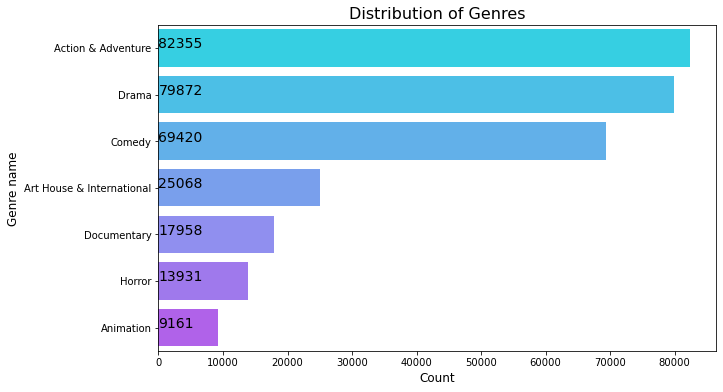

In [32]:
# Barplot representing count of various genres in the predictions

a = plt.cm.cool
plt.figure(figsize=(10,6))
count = pred_test['genres'].value_counts()[:7]
sns.barplot(count.values, count.index, palette=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7)])
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre name', fontsize=12)
plt.title("Distribution of Genres", fontsize=16)

In [50]:
# Rearrange the dataframe as per the top genre
top_genres = list(count.index)
pred_test = pred_test[pred_test['genres'].isin(top_genres)]

pred_test.head(5)

,rotten_tomatoes_link,review_content,movie_year,review_type,genres
0,m/proud_mary,Winston and Henson manage to bring a depth to ...,2018,Fresh,Action & Adventure
1,m/nothing_bad_can_happen,Pitting good against evil with striking intell...,2014,Fresh,Drama
2,m/home_at_the_end_of_the_world,"By the end of the film, you may get the sense ...",2004,Fresh,Drama
3,m/twin-peaks-fire-walk-with-me,Lynch plays with multiple dimensions of existe...,1992,Fresh,Drama
4,m/wonder_woman_2017,Dawn Of Justice proved [Gadot] could handle th...,2017,Fresh,Action & Adventure


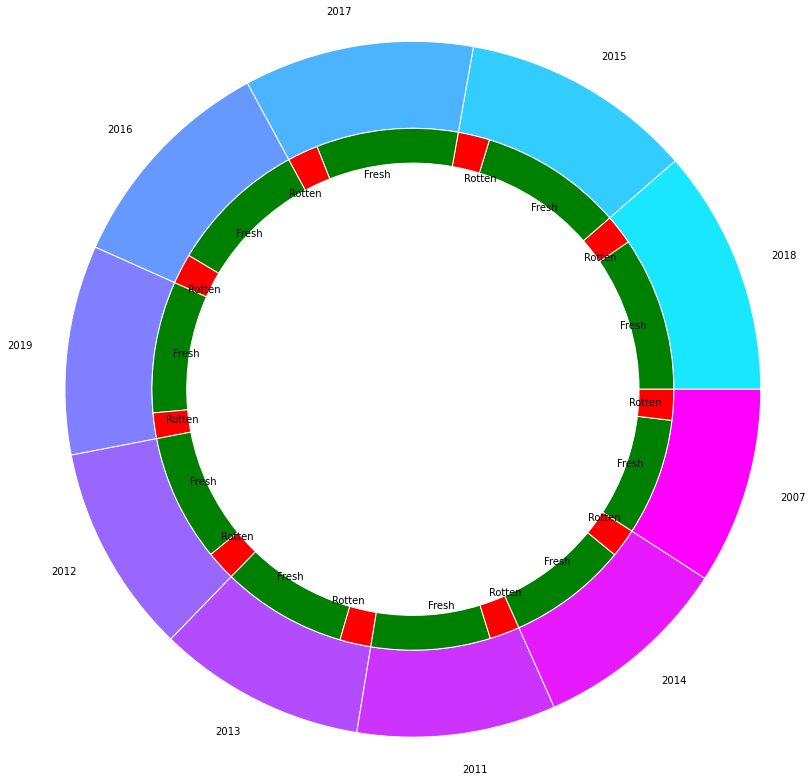

In [34]:
# Pie diagram representing movie release years(outer pie) and 
#fresh/rotten reviews for the movies released in that year(inner pie)

genre_rating_audience = pd.crosstab(pred_test.movie_year, pred_test.review_type, margins=True)
group_names = pred_test.movie_year.value_counts().head(10).index
group_size = pred_test.movie_year.value_counts().head(10)
subgroup_names = ['Fresh','Rotten','Fresh','Rotten','Fresh','Rotten','Fresh','Rotten',
                  'Fresh','Rotten','Fresh','Rotten','Fresh','Rotten','Fresh','Rotten',
                  'Fresh','Rotten','Fresh','Rotten']
size_list = []
for element in group_names:
    size_list.append(genre_rating_audience.loc[element]['Fresh'])
    size_list.append(genre_rating_audience.loc[element]['Rotten'])
subgroup_size = size_list

fig, ax = plt.subplots()
ax.axis('equal')
outter_pie, _ = ax.pie(group_size, radius=4, labels=group_names,
                       colors=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7),a(0.8),a(0.9),a(1.0)])
plt.setp(outter_pie, width=1, edgecolor='white') 
inner_pie, _ = ax.pie(subgroup_size, radius=3, labels=subgroup_names, labeldistance=0.83,
                      colors=['green','red', 'green','red', 'green','red', 'green','red',
                              'green','red', 'green','red', 'green','red', 'green','red', 
                              'green','red', 'green','red'])
plt.setp(inner_pie, width=0.4, edgecolor='white')
plt.margins(0,0)
plt.show()

In [36]:
# Table representing the count of fresh/rotten reviews for each genre
genre_rating_audience = pd.crosstab(pred_test.genres, pred_test.review_type, margins=True)
genre_rating_audience.style.background_gradient(cmap='summer_r')

review_type,Fresh,Rotten,All
genres,,,
Action & Adventure,64864,17491,82355
Animation,7733,1428,9161
Art House & International,21850,3218,25068
Comedy,53989,15431,69420
Documentary,16222,1736,17958
Drama,65973,13899,79872
Horror,10664,3267,13931
All,241295,56470,297765


In [48]:
65973/79872,64864/82355

(0.8259840745192307, 0.7876145953494019)

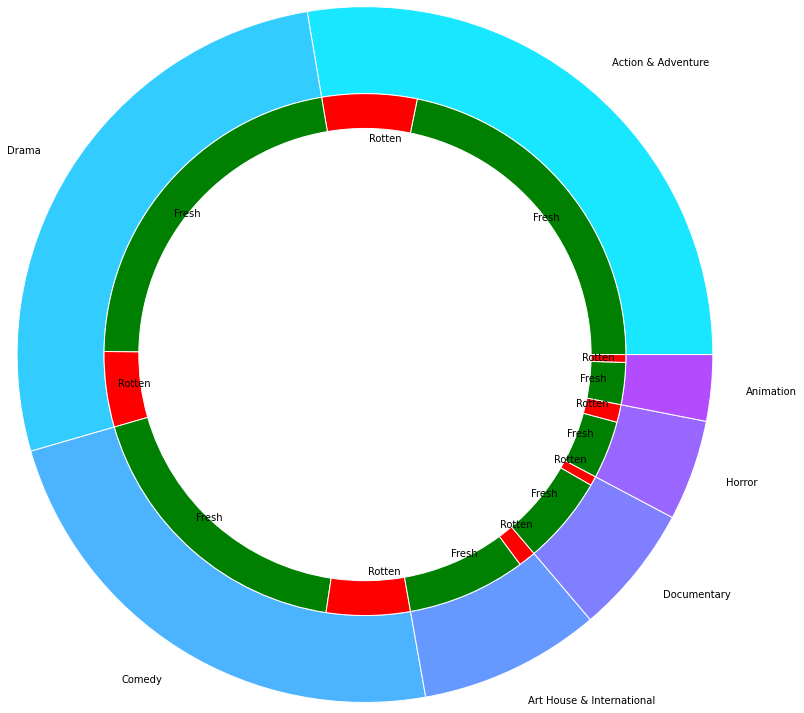

In [37]:
# Pie diagram representing movie genres(outer pie) and 
#fresh/rotten reviews for the movies in perticular genre(inner pie)

group_names = pred_test.genres.value_counts().head(7).index
group_size = pred_test.genres.value_counts().head(7)
subgroup_names = ['Fresh','Rotten','Fresh','Rotten','Fresh','Rotten','Fresh','Rotten',
                  'Fresh','Rotten','Fresh','Rotten','Fresh','Rotten']
size_list = []
for element in group_names:
    size_list.append(genre_rating_audience.loc[element]['Fresh'])
    size_list.append(genre_rating_audience.loc[element]['Rotten'])
subgroup_size = size_list

fig, ax = plt.subplots()
ax.axis('equal')
outter_pie, _ = ax.pie(group_size, radius=4, labels=group_names,
                       colors=[a(0.1),a(0.2),a(0.3),a(0.4),a(0.5),a(0.6),a(0.7)])
plt.setp(outter_pie, width=1, edgecolor='white') 
inner_pie, _ = ax.pie(subgroup_size, radius=3, labels=subgroup_names, labeldistance=0.83,
                      colors=['green','red', 'green','red', 'green','red', 'green','red',
                              'green','red', 'green','red', 'green','red'])
plt.setp(inner_pie, width=0.4, edgecolor='white')
plt.margins(0,0)
plt.show()

In [38]:
stopwords = set(STOPWORDS)
def topicWordCloud(subset):
    wordcloud = WordCloud(width=1800, height=1200,
                      background_color='white',
                      stopwords=stopwords,
                      max_words=200,
                      min_font_size=20,
                      random_state=42).generate(str(subset))
    return wordcloud

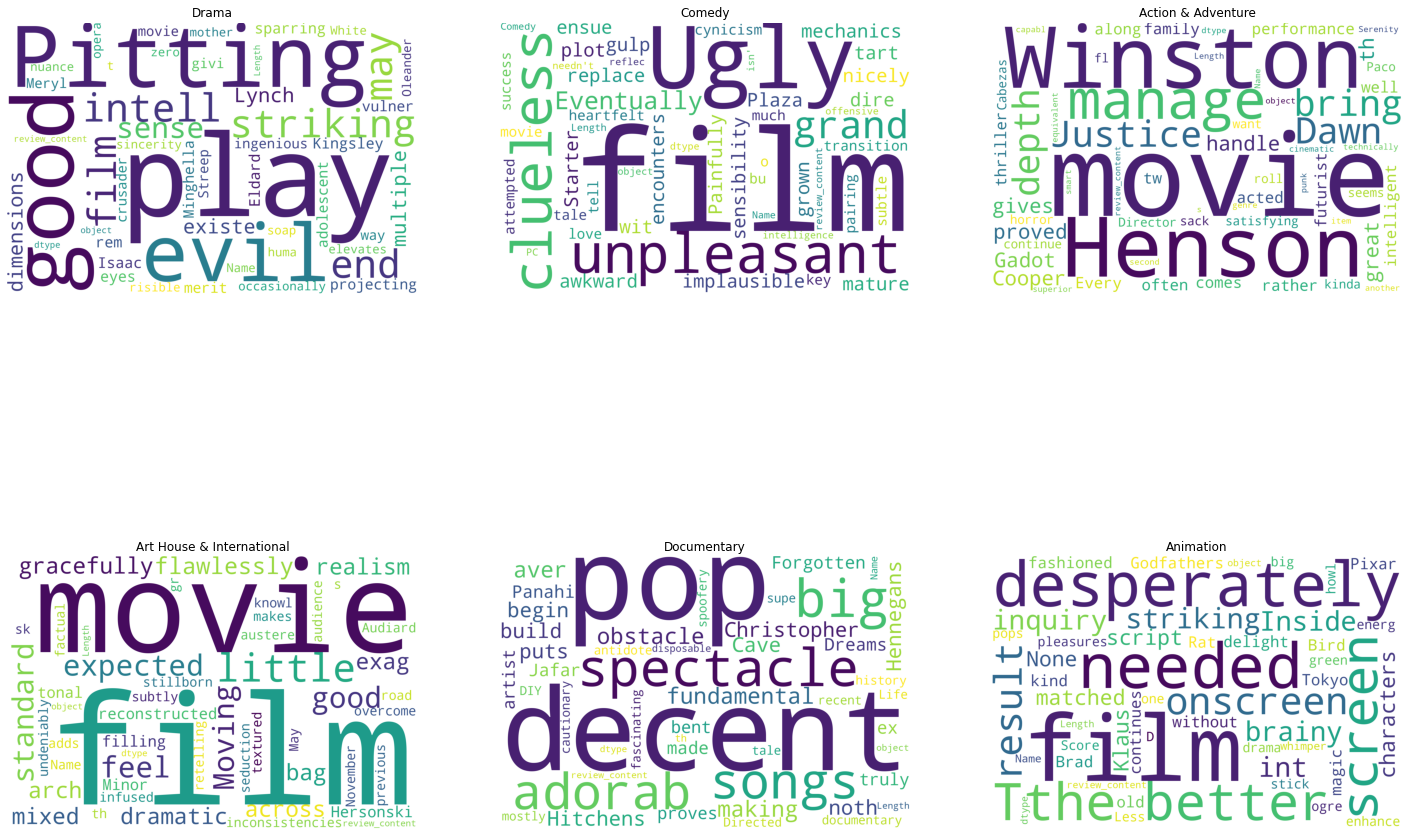

In [39]:
# Word Clouds of movie reviews of top 6 movie genre 

genres_list = ['Drama', 'Comedy', 'Action & Adventure', 'Art House & International', 'Documentary', 'Animation']

fig = plt.figure(figsize=(25, 18), facecolor=None)
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)
    subset = pred_test[pred_test['genres'] == genres_list[i]]['review_content']
    plot_title = genres_list[i]
    wordcloud = topicWordCloud(subset)
    plt.title(plot_title)
    ax.imshow(wordcloud)
    ax.axis('off')

Number of Positive Reviews for Action & Adventure Genre :64864
Number of Negative Reviews for Action & Adventure Genre :17491


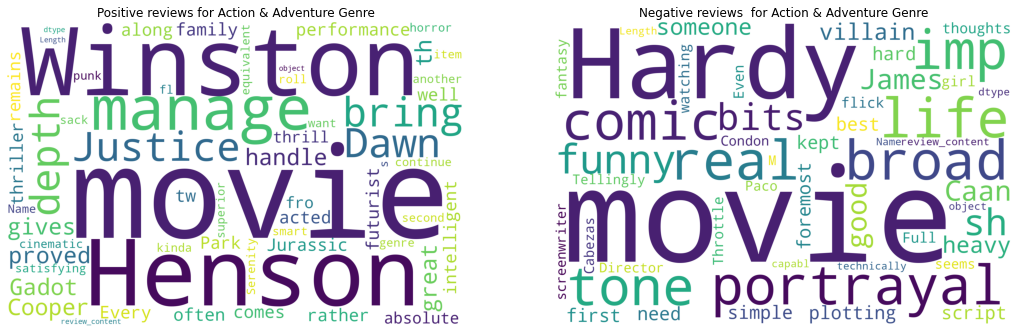

In [40]:
# Word Clouds along with the count of positive and negative reviews for the Action & Adventure Genre

fig = plt.figure(figsize=(18, 12), facecolor=None)
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    if i+1 == 1:
        subset = pred_test[pred_test['review_type'] == 'Fresh']
        subset = subset[subset['genres'] == 'Action & Adventure']['review_content']
        print('Number of Positive Reviews for Action & Adventure Genre :' + str(subset.size))
        plot_title = 'Positive reviews for Action & Adventure Genre'
    elif i+1 == 2:
        subset = pred_test[pred_test['review_type'] == 'Rotten']
        subset = subset[subset['genres'] == 'Action & Adventure']['review_content']
        print('Number of Negative Reviews for Action & Adventure Genre :' + str(subset.size))
        plot_title = 'Negative reviews  for Action & Adventure Genre'
    wordcloud = topicWordCloud(subset)
    plt.title(plot_title)
    ax.imshow(wordcloud)
    ax.axis('off')

Number of Positive Reviews for Drama Genre :65973
Number of Negative Reviews Drama Genre :13899


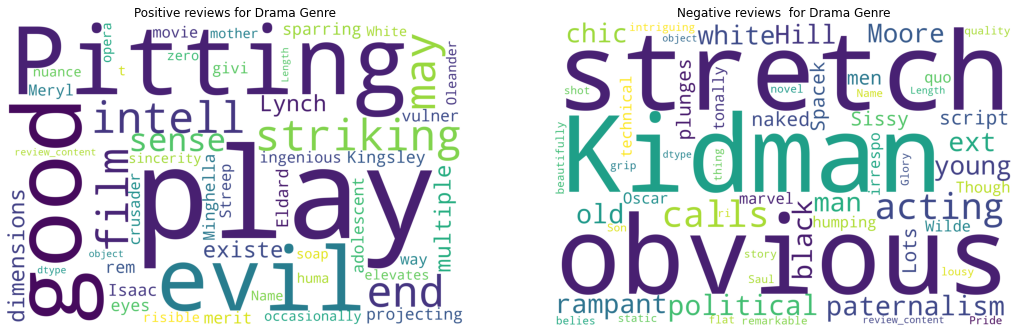

In [41]:
# Word Clouds along with the count of positive and negative reviews for the Drama Genre

fig = plt.figure(figsize=(18, 12), facecolor=None)
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    if i+1 == 1:
        subset = pred_test[pred_test['review_type'] == 'Fresh']
        subset = subset[subset['genres'] == 'Drama']['review_content']
        print('Number of Positive Reviews for Drama Genre :' + str(subset.size))
        plot_title = 'Positive reviews for Drama Genre'
    elif i+1 == 2:
        subset = pred_test[pred_test['review_type'] == 'Rotten']
        subset = subset[subset['genres'] == 'Drama']['review_content']
        print('Number of Negative Reviews Drama Genre :' + str(subset.size))
        plot_title = 'Negative reviews  for Drama Genre'
    wordcloud = topicWordCloud(subset)
    plt.title(plot_title)
    ax.imshow(wordcloud)
    ax.axis('off')